###### Variables that need to be set manually: filename, period_days, ydeg, inc_angle

In [1]:
%matplotlib inline

In [2]:
### Import Packages

import matplotlib.pyplot as plt
import numpy as np
import starry
import pandas as pd
from glob import glob
import os
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import theano
import theano.tensor as tt
import theano.sparse as ts
from scipy.io import readsav
import imageio
from astropy.table import Table
import math

In [5]:
### Starry Configuration
np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True

In [6]:
### Filename

filename = "GaiaDR2_5135093346121603712-SAP.csv"
period_days = 3.17
ydeg = 5
inc_angle = 90
random_seed = 5

In [7]:
### Make new directory for each object if it doesn't already exist

if os.path.exists(filename[:-4])==False:
    os.mkdir(filename[:-4])
else:
    pass

In [8]:
### Function to do everything in one go 
# ADD INTENSITY

def TESS_Squad(filename,ydeg,inc_angle,period_days,random_seed):
    ### -OBTAINING DATA FROM INPUT FILE- ###
    data_table = Table.read(filename,format='csv') # load in data table
    projection_type = ["moll", "ortho", 'rect'] # array with projection types
    sector = data_table["sector"] # set a table equal to the 'sector' column
    sector = np.unique(sector) # extract all unique sectors from 'sector' column
    for sector in sector: # loop through all sectors
        starry_light_curve_fits = []
        sector_Table = data_table[data_table['sector']==sector]  # get data for sector
        sector_flux = np.array(sector_Table['flux']) # set flux for sector
        sector_flux_normalized = sector_flux + 1 # normalize flux to 1
        flux_error = (sector_flux_normalized) * 0.001 # calculate error
        sector_time = np.array(sector_Table['time']) # set time for sector
        sector_time_zero = sector_time - np.amin(sector_time) # set the first time value to 0, and correct the following time values 
        full_rotations = sector_time_zero[-1]/period_days # calculate number of rotations, given period in days
        full_rotations = math.floor(full_rotations) # round to get the number of full rotations
        ### -STARRY SURFACE MAPS- ###
        # Instantiate a map so we can do inference on this dataset
        map = starry.Map(ydeg=ydeg, reflected=False)
        map.obl = 0
        map.inc =inc_angle
        # Set the data vector (the flux and the covariance matrix)
        map.set_data(sector_flux_normalized, C=flux_error**2)
        # Map variables
        mu = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
        mu[0] = 1 # sets the first entry of mu to 0
        mu[1:] = 0 # Sets the rest of the entries in mu to 1
        L = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
        L[0] = 1e0 # sets the first entry of L to 1e0
        L[1:] = 1e-5 # sets the rest of the entries in L to 1e-5
        map.set_prior(L=L) #set the prior mean and covariance of the spherical harmonic coefficients
        # More map variables
        nrot=max(sector_time_zero)/period_days # Calculate the number of rotations
        npts = len(sector_time_zero) # create an array with the same number of data points as time_r5_degree
        theta = np.linspace(0, 360 * nrot, npts) # returns an array that's evenly spaced between 0 and 360(nrot) spaced by npts
        # Rotate to an observer inclination
        map.inc=inc_angle
        kwargs = dict(theta=theta)
        mu, cho_cov = map.solve(**kwargs)
        for projection in projection_type: # loop through all map projection types
            map.show(colorbar=True, projection=projection,file=filename[:-4]+"/"+filename[:-4] +"_sector"+str(sector)+"_ydeg"+str(ydeg)+"_"+projection+"_incangle"+str(inc_angle)+"_map.jpg")
        ### RANDOM MAPS
        for random in range(random_seed):
            np.random.seed(5)
            map.draw()
            map.show(colorbar=True, projection=projection,file=filename[:-4]+"/"+filename[:-4] +"_sector"+str(sector)+"_ydeg"+str(ydeg)+"_"+projection+"_incangle"+str(inc_angle)+str(random)+ "random_map.jpg")
        ### -PLOTTING FULL LIGHT CURVE WITH FULL STARRY FIT- ###
        fig, ax = plt.subplots(1,figsize=(12, 4)) #
        plt.title(filename[:-4] + " Sector " + str(int(sector))+" ydeg "+str(ydeg))
        plt.plot(sector_time, sector_flux_normalized, label="Data", linestyle="none", marker="o", color="blue")
        plt.plot(sector_time, map.flux(**kwargs), label="Starry fit", linewidth=5, color="red")
        plt.legend(prop={'size': 20})
        plt.errorbar(sector_time, sector_flux_normalized, flux_error, alpha=0.1, color="blue")
        ax.set_xlabel("Time (days)", fontsize=20)
        ax.set_ylabel("Flux", fontsize=20)
        plt.savefig(filename[:-4]+"/"+filename[:-4]+"_sector"+str(sector)+"_ydeg"+str(ydeg)+".jpg")
        ### -SPLITTING EACH ROTATION AND STORING THEM INTO THEIR OWN LISTS- ###
        n=1 # Counter for each individual rotation, add 1 when each rotation is fit. Start at first rotation
        new_light_curve = [] # empty list for storing the new fitted light curve
        new_time = [] # empty list for storing the time values for new fitted light curve
        start_index = 0 # have a variable for the index of the start of each rotation
        end_index = 0 # have a variable for the index of the end of each rotation
        end_indices = [] # store values of end indices to mark on plot
        for flux in range(len(sector_flux_normalized)): # stay within the original light curve array
            if n <= full_rotations: # work within number of full rotations
                if sector_time_zero[flux] >= period_days * n: #
                    if n == 1:
                        n+=1
                        end_index = flux+1
                        new_light_curve.append([sector_flux_normalized[0:end_index]])
                        new_time.append([sector_time_zero[0:end_index]])
                        end_indices.append(end_index)
                    else:
                        n+=1
                        start_index = end_index
                        end_index = flux+1
                        new_light_curve.append([sector_flux_normalized[start_index:end_index]])
                        new_time.append([sector_time_zero[start_index:end_index]])
                        end_indices.append(end_index)
        rotation_start_points = []
        rotation_start_time = []
        for index in end_indices:
            rotation_start_points.append(sector_flux_normalized[index])
            rotation_start_time.append(sector_time_zero[index])
        ### -FITTING EACH INDIVIDUAL ROTATION- ###
        for light_curve in range(len(new_light_curve)):
            map = starry.Map(ydeg=ydeg, reflected=False)
            map.obl = 0
            map.inc = 90
            map.set_data(new_light_curve[light_curve][0], C=0.001** 2)
            ## Other map parameters
            mu = np.empty(map.Ny)
            mu[0] = 1
            mu[1:] = 0
            L = np.empty(map.Ny)
            L[0] = 1e0
            L[1:] = 1e-5
            map.set_prior(L=L)
            nrot=1
            npts = len(new_time[light_curve][0])
            theta = np.linspace(0, 360 * nrot, npts)
            kwargs = dict(theta=theta)
            mu, cho_cov = map.solve(**kwargs)
            starry_light_curve_fits.append([map.flux(**kwargs)])
            for projection in projection_type:
                map.show(colorbar=True,figsize=(10,10), projection=projection,dpi=500,file=filename[:-4]+"/"+filename[:-4] +"_sector"+str(sector)+"_ydeg"+str(ydeg)+"_"+projection+"_rotation"+str(light_curve)+".jpg")
        ### -PLOTTING FULL LIGHT CURVE WITH INDIVIDUAL ROTATION FITS- ###
        fig, ax = plt.subplots(1,figsize=(12, 4))
        plt.title(filename[:-4] + " Sector " + str(sector)+" ydeg "+str(ydeg) + " Starry fits")
        plt.scatter(rotation_start_time, rotation_start_points, c="orangered",marker="X",linewidths = 5,zorder=89)
        plt.plot(sector_time_zero, sector_flux_normalized,label="Data",linestyle="none",marker="o",color="blue")
        plt.plot(new_time[0][0], starry_light_curve_fits[0][0],label="Starry fit",linewidth=5,color="red")
        for i in range(len(new_time)):
            plt.plot(new_time[i][0], starry_light_curve_fits[i][0],linewidth=5,color="red")
        plt.legend(prop={'size': 20})
        plt.errorbar(sector_time_zero,sector_flux_normalized , flux_error,alpha=0.1,color="blue")
        ax.set_xlabel("Time (days)", fontsize=20)
        ax.set_ylabel("Flux", fontsize=20)
        plt.savefig(filename[:-4]+"/"+filename[:-4]+"_sector"+str(sector)+"_ydeg"+str(ydeg)+" Starry_Fits.jpg")

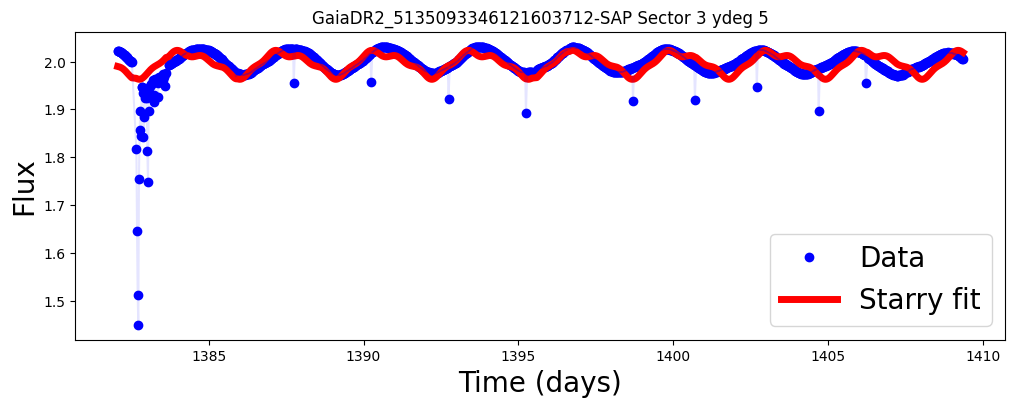

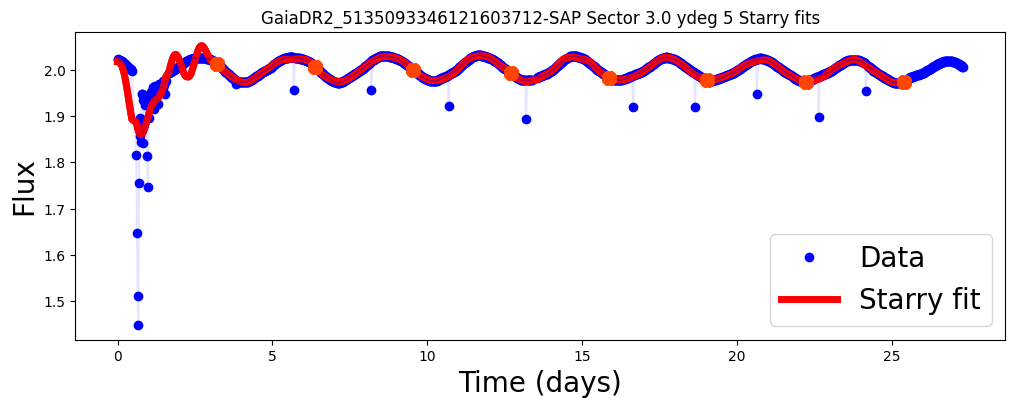

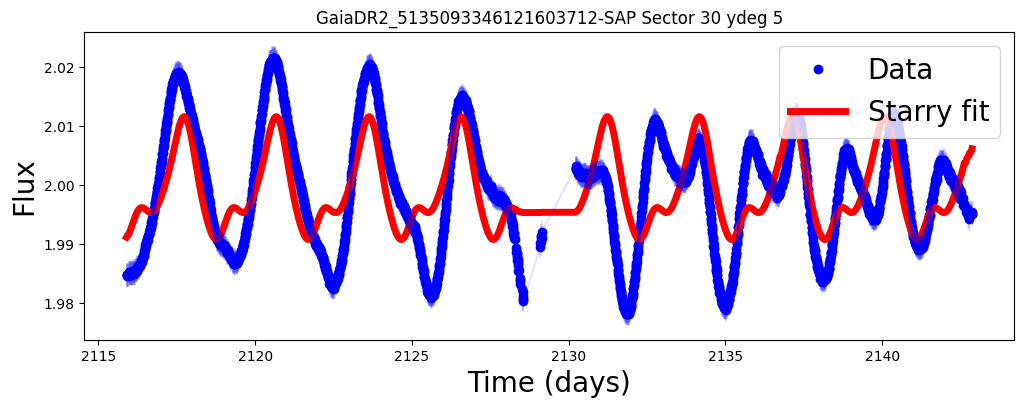

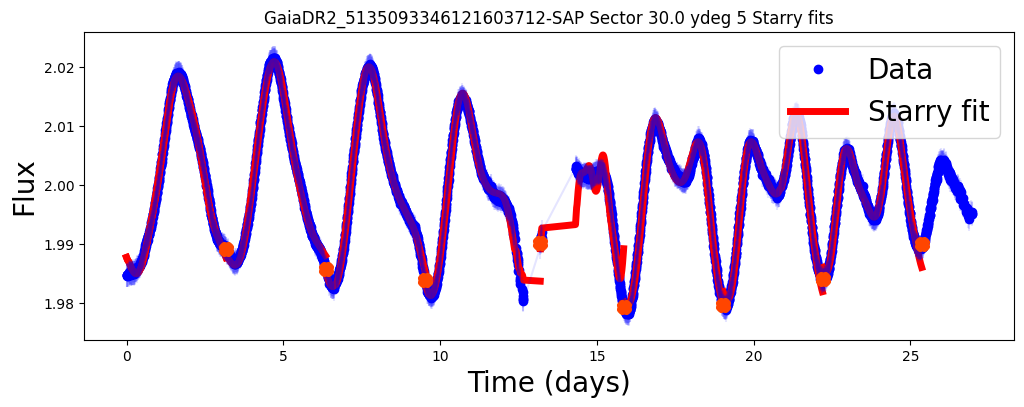

In [9]:
### Apply Function

TESS_Squad(filename,ydeg,inc_angle,period_days,random_seed)